# Mariners Technical Assessment
## Predicting Second Half Slugging
## Scott Matsubara
## 11/15/2023

In [459]:
import pandas as pd
import numpy as np
# ! pip install openpyxl
import math
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# 1. Data Cleaning

In [511]:
train_FHBB = pd.read_excel('data/train_first_half_batted_balls.xlsx', engine='openpyxl')
train_SH_slug = pd.read_excel('train_second_half_slg.xlsx', engine='openpyxl')

In [1026]:
test_FHBB_original = pd.read_excel('data/test_first_half_batted_balls.xlsx', engine='openpyxl')

In [1025]:
test_submission_df = pd.read_excel('data/test_submission_df.xlsx', engine = 'openpyxl')

In [704]:
dictionary = pd.read_excel('data/dictionary.xlsx', engine='openpyxl')
dictionary

,Column,Description
0,month,"An integer corresponding to the month in which the given play took place. 4 corresponds to April, 5 to May, and so on."
1,season,An integer corresponding to the year in which the given play took place.
2,game_id,A unique character identifier signifying a distinct game.
3,inning,An integer corresponding to the inning in which the given play took place.
4,top,"An integer coresponding to whether or not the play took place in the top or bottom of the inning. If this column is 1, then it took place in the top of the inning, if this column is 0, then it took place in the bottom."
5,pa_of_inning,An integer coresponding to the PA number of the half-inning in which the given play took place.
6,batter_id,A unique character identifier signifying a distinct batter.
7,bat_side,"A character signifying the handedness of the batter for a given plate appearance. ""R"" means the batter hit from the right side, ""L"" means the left."
8,pitcher_id,A unique character identifying signifying a distinct pitcher.
9,pitch_side,"A character signifying the handedness of the pitcher for a given plate appearance. ""R"" means the pitcher user their right hand to throw the ball, ""L"" means they used their left."


In [705]:
train_FHBB.head()

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_tilt,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,event_type,slg
0,5,2017,xb9d28ea4,1,1,3,x1a144c53,L,x5a365c39,R,2,2,2,Fastball,95.520002,2195.511800,197.567006,12:30:00,6.076918,1.131171,5.509253,-14.508357,17.015614,4.866302,2.995102,-0.624306,67.386173,-13.940554,-3.331062,NaN,12.3166,field_out,0
1,4,2017,xe759eb85,7,0,4,xbed99798,L,x74a5c086,L,1,1,2,Sinker,86.608715,2209.950094,88.530611,09:00:00,4.598388,-3.290455,5.827094,-36.348362,1.274052,-19.603756,2.059211,-0.866770,86.749105,-7.099422,-25.003463,NaN,13.8123,field_out,0
2,4,2017,x97331f0a,5,1,2,x1a144c53,L,x607b9354,R,1,2,0,Slider,82.602484,2347.988740,152.853349,11:00:00,6.079954,1.993246,5.784996,-32.741526,8.329462,-3.341363,2.658454,0.151087,97.727244,30.130697,-1.464437,2676.402802,367.1120,double_play,0
3,4,2017,x07a52b2a,3,0,7,x3c899258,R,xd7aff4b8,R,1,1,2,Fastball,94.551664,2122.917873,240.983269,02:00:00,6.084905,2.483645,5.427153,-22.130647,9.660908,14.986313,2.421182,-0.224985,103.634872,3.777952,-8.210238,959.542630,99.5115,single,1
4,6,2017,xbcf9f4e4,8,0,2,xbed99798,L,x7cf545bd,L,1,1,1,Slider,80.836145,2486.799467,180.682600,12:00:00,6.077955,-2.337797,5.600363,-31.738645,11.244203,0.112744,2.451857,-0.607118,92.305361,25.288136,16.995705,2467.164262,364.5160,field_out,0


In [706]:
len(train_FHBB)

60294

In [707]:
train_SH_slug.head()

,season,batter_id,second_half_slgcon
0,2017,x7a4b2e79,0.393162
1,2017,xb96dc32c,0.468085
2,2017,xbed99798,0.323529
3,2017,x540830e0,0.418478
4,2017,x717d3ff9,0.500000


In [708]:
len(train_SH_slug)

374

### Merge data on batter_id so that we have the slugging percentage for each player and each year 

In [804]:
data = train_FHBB.merge(train_SH_slug,on=['batter_id','season'],how='inner')

In [805]:
len(data)

60294

### Check for missing data and duplicate columns

In [806]:
def get_missing_val_columns(data):
    # Check for missing values in each column
    missing_values = data.isnull().sum()

    # Display columns with missing values (if any)
    return missing_values[missing_values > 0]

get_missing_val_columns(data)

pitch_type                   1260
pitch_release_speed           234
pitch_spin_rate              1820
pitch_spin_axis               532
pitch_tilt                    537
pitch_release_height          234
pitch_release_side            234
pitch_extension               407
pitch_vert_break              245
pitch_induced_vert_break      245
pitch_horz_break              245
pitch_plate_height            224
pitch_plate_side              224
hit_exit_speed               6112
hit_vert_exit_angle          6103
hit_horz_exit_angle          6103
hit_spin_rate               17507
hit_distance                 6809
dtype: int64

### Now we have to decide how to handle these missing values. 

### Starting with the variable hit_spin_rate, which has missing values for nearly 1/6 of the data. Because of this, we will not include this variable for our analysis.

In [807]:
data[data.hit_exit_speed.isna()].describe()

,month,season,inning,top,pa_of_inning,pre_balls,pre_strikes,pre_outs,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,slg,second_half_slgcon
count,6112.00000,6112.000000,6112.000000,6112.000000,6112.000000,6112.000000,6112.00000,6112.000000,5893.000000,5685.000000,5887.000000,5893.000000,5893.000000,5892.000000,5888.000000,5888.000000,5888.000000,5891.000000,5891.000000,0.0,9.000000,9.000000,29.000000,9.000000,6112.000000,6112.000000
mean,5.12680,2018.207461,4.886453,0.497055,2.896597,1.003109,1.01178,0.908213,87.661964,2180.956179,184.940712,5.890982,0.966674,6.063759,-28.304161,8.268231,2.705245,2.277052,0.013924,NaN,-61.694556,27.083826,4812.299882,1.453317,0.277487,0.561812
std,0.78176,1.308491,2.591137,0.500032,1.728440,0.997209,0.82061,0.819648,5.820879,320.169967,67.942234,0.626763,1.941692,0.556957,12.340811,7.927597,9.723725,0.688204,0.625797,NaN,11.921059,57.749445,2298.579661,1.095349,0.637222,0.126349
min,4.00000,2017.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,44.100647,654.592338,0.596896,0.030058,-5.270480,3.614831,-132.189432,-20.487449,-25.341028,-1.275391,-3.702581,NaN,-83.743654,-44.812390,787.956889,0.496519,0.000000,0.284768
25%,4.00000,2017.000000,3.000000,0.000000,2.000000,0.000000,0.00000,0.000000,83.714336,2029.949889,140.551148,5.665198,0.050772,5.709636,-35.422171,3.806486,-5.068949,1.818370,-0.399393,NaN,-69.120134,-20.469396,2951.751205,0.753516,0.000000,0.474026
50%,5.00000,2018.000000,5.000000,0.000000,3.000000,1.000000,1.00000,1.000000,88.892889,2213.711806,201.950029,5.961840,1.667780,6.074590,-25.449436,9.539243,4.284918,2.253151,0.017812,NaN,-62.161795,30.843204,4618.999559,1.083440,0.000000,0.551724
75%,6.00000,2019.000000,7.000000,1.000000,4.000000,2.000000,2.00000,2.000000,92.069354,2372.475008,230.673931,6.245437,2.293067,6.424618,-18.936073,14.075552,10.806589,2.730606,0.421104,NaN,-51.342190,47.688691,7305.368116,1.927490,0.000000,0.633803
max,6.00000,2023.000000,16.000000,1.000000,18.000000,4.000000,3.00000,2.000000,102.495031,3427.815262,359.863983,7.399123,5.184185,8.925558,1.853355,33.261540,23.194627,7.169992,4.257718,NaN,-46.801277,141.104003,7899.274620,3.788550,4.000000,0.919075


### Then we see that hit_exit_speed values for hit_exit_speed are missing and that many of these values are missing from this column are missing from the exit angles columns. Lets replace missing values in these columns with the average based on player, year, and slg 

In [808]:
data.drop(columns = ['hit_spin_rate'],inplace=True)

In [809]:
data[['hit_exit_speed','hit_vert_exit_angle','hit_horz_exit_angle','hit_distance']] = data[['hit_exit_speed','hit_vert_exit_angle','hit_horz_exit_angle','hit_distance']].fillna(0)

data['hit_distance'] = data.groupby(['batter_id','season', 'slg'])['hit_distance'].transform(lambda x: x.fillna(x.mean()))
data['hit_exit_speed'] = data.groupby(['batter_id', 'season','slg'])['hit_exit_speed'].transform(lambda x: x.fillna(x.mean()))
data['hit_vert_exit_angle'] = data.groupby(['batter_id', 'season','slg'])['hit_vert_exit_angle'].transform(lambda x: x.fillna(x.mean()))
data['hit_horz_exit_angle'] = data.groupby(['batter_id', 'season','slg'])['hit_horz_exit_angle'].transform(lambda x: x.fillna(x.mean()))

### Next lets look at rows with missing values from the pitch side of things. 

In [810]:
get_missing_val_columns(data)

pitch_type                  1260
pitch_release_speed          234
pitch_spin_rate             1820
pitch_spin_axis              532
pitch_tilt                   537
pitch_release_height         234
pitch_release_side           234
pitch_extension              407
pitch_vert_break             245
pitch_induced_vert_break     245
pitch_horz_break             245
pitch_plate_height           224
pitch_plate_side             224
dtype: int64

In [811]:
data.pitch_type.value_counts()

pitch_type
Fastball       24391
Slider          9569
ChangeUp        6589
Curveball       4818
Sinker          4730
Cutter          2951
Undefined       2355
Four-Seam       1774
Changeup         797
Splitter         735
Other            319
KnuckleBall        6
Name: count, dtype: int64

### We see that there are many pitch types are labeled as 'Undefined', lets impute the missing pitch type as 'Undefined'

### Then we will impute the average values for the rest of the missing rows based on these columns based on the pitcher and pitch type

In [812]:
data.drop(columns = ['pitch_tilt'],inplace=True)

### During this process, came across the issue where pitch tilt is a datetime data type. For the sake of this project, we will remove this column because it will likely not be useful

In [813]:
data['pitch_type'] = data['pitch_type'].fillna('Undefined')

pitch_missing_columns = ['pitch_release_speed','pitch_spin_rate','pitch_spin_axis','pitch_release_height','pitch_release_side',\
                         'pitch_extension','pitch_vert_break','pitch_induced_vert_break','pitch_horz_break','pitch_plate_height','pitch_plate_side']

for col in pitch_missing_columns:
    # Calculate the mean of spin rate and speed for each combination of pitcher and pitch type
    group_means = data.groupby(['pitcher_id','pitch_type'])[col].transform('median')
    
    # Replace NA values in speed and spin rate with the corresponding group mean
    data[col] = data[col].fillna(group_means)

In [814]:
get_missing_val_columns(data)

pitch_release_speed         112
pitch_spin_rate             306
pitch_spin_axis             133
pitch_release_height        112
pitch_release_side          112
pitch_extension             119
pitch_vert_break            118
pitch_induced_vert_break    118
pitch_horz_break            118
pitch_plate_height          111
pitch_plate_side            111
dtype: int64

### After the process of imputing data, we can see that some values are still missing. The values that are currently still missing are rows where either the pitcher has never thrown that pitch before or that pitch from that pitcher consistently does not have good data. Lets just replace these values with 0 for now.

In [815]:
data = data.fillna(0)
len(data)

60294

In [816]:
get_missing_val_columns(data)

Series([], dtype: int64)

### Check the descriptions of each feature

In [817]:
data.describe()

,month,season,inning,top,pa_of_inning,pre_balls,pre_strikes,pre_outs,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_distance,slg,second_half_slgcon
count,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000,60294.000000
mean,5.118337,2019.711132,4.808953,0.508309,2.938734,1.092646,1.074701,0.950775,87.510620,2170.152541,182.011367,5.862974,0.873523,6.086861,-28.149072,8.194161,2.217046,2.392394,0.021459,78.866137,10.921901,-0.739575,151.534043,0.573838,0.567621
std,0.789137,2.249648,2.565876,0.499935,1.732494,1.005339,0.810607,0.816259,6.977062,361.506152,68.436216,0.617917,1.953193,0.606024,12.488174,7.967077,9.926938,0.579754,0.557850,29.808999,25.454983,22.246168,138.043074,0.987262,0.124994
min,3.000000,2017.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.247069,0.000000,-264.018215,-22.594500,-30.138418,-1.275391,-4.073878,0.000000,-88.557670,-179.730376,0.000000,0.000000,0.284768
25%,4.000000,2018.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,83.506983,2035.019503,137.751854,5.620264,-0.827354,5.751629,-35.605708,3.277077,-5.808341,2.007658,-0.360515,73.788823,-1.645230,-15.539936,9.864973,0.000000,0.478528
50%,5.000000,2019.000000,5.000000,1.000000,3.000000,1.000000,1.000000,1.000000,88.807416,2213.379497,200.317617,5.927394,1.604882,6.122042,-25.578657,9.323728,3.619294,2.390216,0.022313,88.450089,9.501703,0.000000,129.600000,0.000000,0.549180
75%,6.000000,2022.000000,7.000000,1.000000,4.000000,2.000000,2.000000,2.000000,92.170546,2373.124259,227.269816,6.212080,2.250661,6.462679,-18.341375,14.422761,10.562724,2.780488,0.405369,97.736971,27.299065,13.416721,279.187000,1.000000,0.644330
max,6.000000,2023.000000,18.000000,1.000000,18.000000,4.000000,3.000000,2.000000,102.899330,3576.049203,359.932908,7.834682,5.663761,10.012332,1.853355,33.261540,70.925895,7.169992,4.257718,120.932140,89.009826,178.482173,521.988000,4.000000,0.919075


### The data looks accurate with all the max and min values seeming accurate. One potential outlier, is the max hit distance of 521. Lets look at hits that were measured to be more than 500 feet

In [818]:
data[data.hit_distance>=500]

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_distance,event_type,slg,second_half_slgcon
13847,5,2018,xdfaa3028,9,0,3,xd8f27801,R,x66ca7363,R,0,1,1,Fastball,93.481320,2364.932328,214.848680,5.585993,1.636917,6.596580,-16.085299,14.873586,10.376431,2.686399,0.284109,94.720402,27.746289,6.703011,513.705,field_out,0,0.575758
38948,5,2019,xe2655f46,4,0,2,x4a44365a,R,x7afd1241,R,2,0,1,Fastball,94.223841,1956.635525,219.142464,6.645733,2.549381,6.052054,-18.810212,12.215602,9.966135,2.028940,0.619861,108.223890,25.290994,-27.477887,521.988,home_run,4,0.622047


### One of these hits was a field out which is impossible since no field has greater dimensions than 500 feet. Also there is no batted ball in the StatCast era that has been measured at 521 feet, so lets remove these from the data.

In [819]:
data = data[data.hit_distance<500]

In [820]:
data[(data.hit_distance>450) & (data.slg!=4)]

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_distance,event_type,slg,second_half_slgcon


### There are no more balls that were hit further than 450 that did not result in a home run.

In [821]:
len(data)

60292

# 2. Feature Engineering

### Lets first create a same hand flag and a ground ball flag

In [822]:
def same_hand(row):
    if(row['bat_side']==row['pitch_side']):
        return 'Same_Hand'
    else: 
        return 'Opposite_Hand'
    
data['same_hand'] = data.apply(same_hand,axis=1)

In [823]:
# according to MLB Glossary: https://www.mlb.com/glossary/statcast/launch-angle, lets create a flag for ground ball 
# lets also create a flag 
def ground_ball(x):
    if(x<10):
        return 1
    else: 
        return 0
    
data['ground_ball'] = data['hit_vert_exit_angle'].apply(lambda x: ground_ball(x))

# based on this, https://www.mlb.com/glossary/statcast/barrel, lets also create a flag for barrel rate
def barrel(row):
    exit_velo = math.floor(row['hit_exit_speed']/1)
    
    if(exit_velo<98):
        return 0
    
    barrel_range = exit_velo - 98
    range_upper = 30+barrel_range
    range_lower = 26-barrel_range
    
    if((row['hit_vert_exit_angle']>range_lower) & (row['hit_vert_exit_angle']<range_upper)):
        return 1
    else:
        return 0

data['barrel'] = data.apply(barrel,axis=1)

### Now lets group the pitches into categories before we can create a new variable that is the slugging percentage for each player based on pitch 

In [824]:
data.pitch_type.value_counts()

pitch_type
Fastball       24389
Slider          9569
ChangeUp        6589
Curveball       4818
Sinker          4730
Undefined       3615
Cutter          2951
Four-Seam       1774
Changeup         797
Splitter         735
Other            319
KnuckleBall        6
Name: count, dtype: int64

In [825]:
# Group pitches into 3 types: Fastball, Breaking Ball, and Changeup
def pitch_categorization(x):
    if ((x == 'Fastball') | (x == 'Four-Seam') | (x == 'Four-Seam') | (x == 'Sinker') | (x == 'Cutter')):
        return 'Fastball'
    if ((x == 'ChangeUp') | (x == 'Changeup') | (x == 'Splitter')):
        return 'Changeup'
    if ((x == 'Slider') | (x == 'Curveball')):
        return 'BreakingBall'
    else: 
        return "Other"
    
data['pitch_type'] = data['pitch_type'].apply(lambda x: pitch_categorization(x))
data['pitch_type'].unique()

array(['Fastball', 'BreakingBall', 'Changeup', 'Other'], dtype=object)

In [826]:
def get_slg_by_groups(data,col):
    df = data.copy()
    
    # Calculate the mean 'slg' for each player for each pitch type
    grouped_means = df.groupby(['batter_id','season',col])['slg'].mean()

    # Unstack the 'pitch_type' level of the index to create columns
    unstacked_means = grouped_means.unstack(level=col)

    # Join the unstacked means back to the original DataFrame
    # This assumes that 'player' is unique in df. If not, you'll need to drop duplicates or aggregate first.
    df = df.join(unstacked_means, on=['batter_id','season'], rsuffix='_avg')

    # Rename the new columns as needed
    new_column_names = {pt: f"{pt}_avg_slg" for pt in unstacked_means.columns}
    df.rename(columns=new_column_names, inplace=True)
    
    return df

data_new = get_slg_by_groups(data,'pitch_type')

In [827]:
data_new = get_slg_by_groups(data_new,'same_hand')

In [733]:
data_new.head()

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_distance,event_type,slg,second_half_slgcon,same_hand,ground_ball,barrel,BreakingBall_avg_slg,Changeup_avg_slg,Fastball_avg_slg,Other_avg_slg,Opposite_Hand_avg_slg,Same_Hand_avg_slg
0,5,2017,xb9d28ea4,1,1,3,x1a144c53,L,x5a365c39,R,2,2,2,Fastball,95.520002,2195.511800,197.567006,6.076918,1.131171,5.509253,-14.508357,17.015614,4.866302,2.995102,-0.624306,67.386173,-13.940554,-3.331062,12.3166,field_out,0,0.518519,Opposite_Hand,1,0,0.289474,0.416667,0.538462,0.0,0.534884,0.276596
1,4,2017,x97331f0a,5,1,2,x1a144c53,L,x607b9354,R,1,2,0,BreakingBall,82.602484,2347.988740,152.853349,6.079954,1.993246,5.784996,-32.741526,8.329462,-3.341363,2.658454,0.151087,97.727244,30.130697,-1.464437,367.1120,double_play,0,0.518519,Opposite_Hand,0,0,0.289474,0.416667,0.538462,0.0,0.534884,0.276596
2,5,2017,xfdc60eaa,3,1,1,x1a144c53,L,x908a9e5b,R,2,1,0,Fastball,90.806875,2329.198950,224.834581,6.046486,2.241192,5.497186,-20.737240,14.044334,12.244054,2.568387,0.460382,100.223808,20.522501,-29.482297,322.2840,double,2,0.518519,Opposite_Hand,0,0,0.289474,0.416667,0.538462,0.0,0.534884,0.276596
3,6,2017,x431b567d,1,1,3,x1a144c53,L,xfa261d60,L,0,0,2,Fastball,87.880626,2212.006066,108.966430,5.977270,-1.869720,5.568947,-28.052566,8.418280,-20.025890,1.225657,-0.506996,94.671710,14.048989,2.142054,267.3660,single,1,0.518519,Same_Hand,0,0,0.289474,0.416667,0.538462,0.0,0.534884,0.276596
4,4,2017,x235f0b70,4,1,2,x1a144c53,L,x6150aa58,R,2,1,1,Fastball,90.238806,1968.028385,222.831916,5.407447,1.532246,6.736279,-20.719182,12.449585,10.165042,2.419686,0.126732,101.827295,13.471033,-21.959423,254.3960,field_out,0,0.518519,Opposite_Hand,0,0,0.289474,0.416667,0.538462,0.0,0.534884,0.276596


### Hitters that pull the ball for power (have high slugging on inside pitches) are likely going to continue this trend in the second half. Create new variable that is the slugging percentage on inside pitches and outside pitches 

(array([2.000e+00, 1.000e+00, 9.000e+00, 7.000e+00, 6.000e+00, 1.100e+01,
        1.000e+01, 1.300e+01, 1.000e+00, 7.000e+00, 1.700e+01, 5.500e+01,
        1.630e+02, 5.390e+02, 1.396e+03, 2.830e+03, 4.672e+03, 6.633e+03,
        7.958e+03, 8.698e+03, 8.384e+03, 7.098e+03, 5.384e+03, 3.424e+03,
        1.847e+03, 7.460e+02, 2.460e+02, 6.600e+01, 3.000e+01, 1.600e+01,
        7.000e+00, 4.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-4.07387793, -3.86558803, -3.65729813, -3.44900824, -3.24071834,
        -3.03242844, -2.82413854, -2.61584864, -2.40755874, -2.19926884,
        -1.99097894, -1.78268904, -1.57439914, -1.36610924, -1.15781934,
        -0.94952944, -0.74123954, -0.53294964, -0.32465974, -0.11636984,
         0.09192006,  0.30020995,  0.50849985,  0.71678975,  0.92507965,
         1.13336955,  1.34165945,  1.54994935,  1.75823925,  1.96652915,
         2.17481905,  2.38310895,  2.59139885,  2.79968875,  3.0

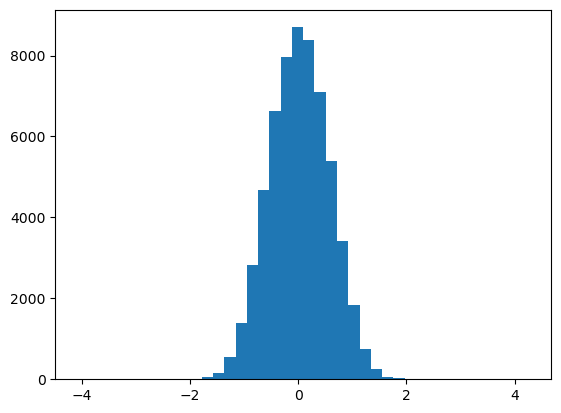

In [734]:
plt.hist(data.pitch_plate_side,bins=40)

### After further analysis, this variable is measured from as the distance on a line from second base to home plate. There is no data in the data set that measures the pitch on the "x-axis" that measures if the pitch is inside or outside, so we will not include the feature engineered variable I. measured

### For the variable hit_vert_exit_angle, there might be an optimal point that indicates the best slugging percentage. However, when looking at the below plot, we can clearly see that the relationship is linear 

Text(0, 0.5, 'Second Half Slugging')

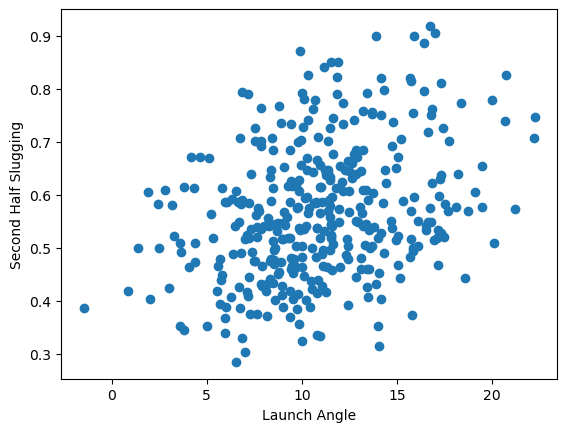

In [735]:
plt.scatter(X['hit_vert_exit_angle'],y)
plt.xlabel("Launch Angle")
plt.ylabel("Second Half Slugging")

### Create the new dataframe that we will use for modeling

In [736]:
data_new.columns

percentile_cols = ['hit_exit_speed','hit_distance']
mean_cols = ['hit_horz_exit_angle','hit_vert_exit_angle','BreakingBall_avg_slg','Changeup_avg_slg', 'Fastball_avg_slg','Opposite_Hand_avg_slg', 'Same_Hand_avg_slg','slg','second_half_slgcon','barrel','ground_ball']

aggregations = ({col: lambda x: np.percentile(x, 90) for col in percentile_cols})
aggregations.update({col: 'mean' for col in mean_cols})

model_data = data_new.groupby(['batter_id','season']).agg(aggregations)
model_data.head()

hit_exit_speed  hit_distance  hit_horz_exit_angle  \
batter_id season                                                      
x007bc3de 2017        102.521615      322.5140            -0.837563   
          2018        104.547031      331.2003             2.702738   
x0129dfbe 2017        108.945742      362.9058             4.442230   
x028e87df 2022        106.013982      365.8805           -10.971965   
x055e4b8f 2021        103.860000      321.3692            11.577649   

                  hit_vert_exit_angle  BreakingBall_avg_slg  Changeup_avg_slg  \
batter_id season                                                                
x007bc3de 2017              10.460620              0.549020          0.407407   
          2018               7.009264              0.781250          0.605263   
x0129dfbe 2017               9.845613              0.325000          0.555556   
x028e87df 2022              13.115522              0.789474          0.956522   
x055e4b8f 2021               5.019927              0.357143          0.250000   

                  Fastball_avg_slg  Opposite_Hand_avg_slg  Same_Hand_avg_slg  \
batter_id season                                                               
x007bc3de 2017            0.540146               0.505208           0.547170   
          2018            0.505155               0.541985           0.617021   
x0129dfbe 2017            0.684685               0.533784           0.686275   
x028e87df 2022            0.575472               0.595745           0.719424   
x055e4b8f 2021            0.700000               0.468468           0.250000   

                       slg  second_half_slgcon    barrel  ground_ball  
batter_id season                                                       
x007bc3de 2017    0.514286            0.437500  0.032653     0.600000  
          2018    0.561798            0.517544  0.050562     0.601124  
x0129dfbe 2017    0.572864            0.628743  0.115578     0.547739  
x028e87df 2022    0.688172            0.644330  0.086022     0.451613  
x055e4b8f 2021    0.429630            0.352000  0.022222     0.570370

In [737]:
get_missing_val_columns(model_data)

Same_Hand_avg_slg    38
dtype: int64

In [738]:
model_data = model_data.fillna(0)

# 3. Feature Analysis 

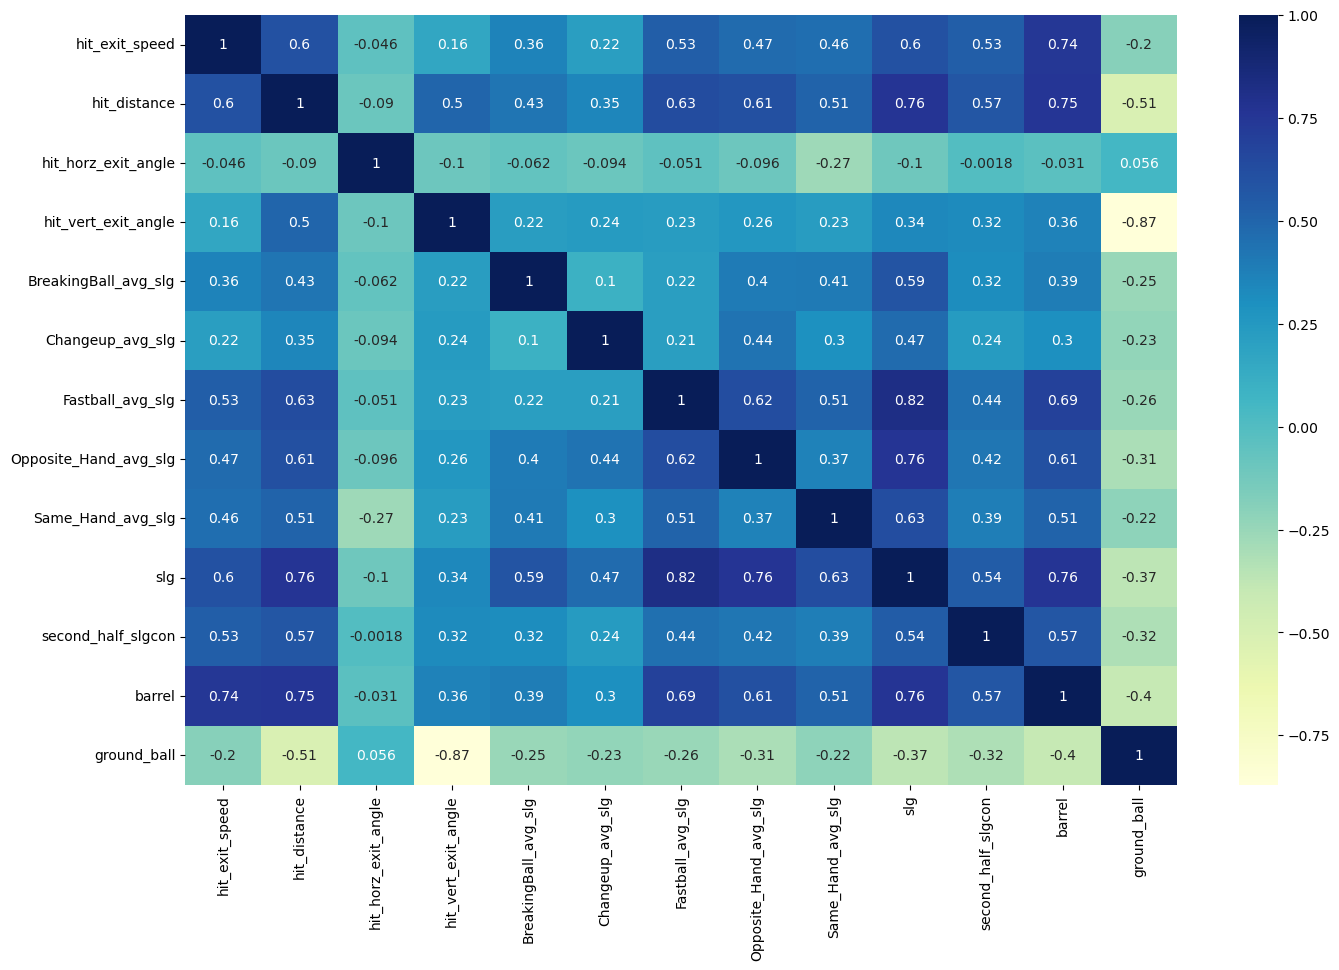

In [739]:
import seaborn as sns
plt.figure(figsize=(16, 10))  # You can adjust the size as needed
dataplot = sns.heatmap(model_data.corr(), cmap="YlGnBu", annot=True) 

### We can see that all of the variables have some correlation to second half slugging besides Horizontal Exit Angle. We can opt to neglect that from modeling

### Interaction Terms


### Finally, lets try using interaction terms to see if our hypothesis about high slugging on pitches like FB and BB together as well as other combinations can influence second half performance

In [781]:
model_data['FB_BB_slg'] = model_data['Fastball_avg_slg'] * model_data['BreakingBall_avg_slg']
model_data['FB_CH_slg'] = model_data['Fastball_avg_slg'] * model_data['Changeup_avg_slg']
model_data['BB_CH_slg'] = model_data['BreakingBall_avg_slg'] * model_data['Changeup_avg_slg']

model_data['SameHand_FB_slg'] = model_data['Same_Hand_avg_slg'] * model_data['Fastball_avg_slg']
model_data['SameHand_BB_slg'] = model_data['Same_Hand_avg_slg'] * model_data['BreakingBall_avg_slg']
model_data['SameHand_CH_slg'] = model_data['Same_Hand_avg_slg'] * model_data['Changeup_avg_slg']

model_data['OppHand_FB_slg'] = model_data['Opposite_Hand_avg_slg'] * model_data['Fastball_avg_slg']
model_data['OppHand_BB_slg'] = model_data['Opposite_Hand_avg_slg'] * model_data['BreakingBall_avg_slg']
model_data['OppHand_CH_slg'] = model_data['Opposite_Hand_avg_slg'] * model_data['Changeup_avg_slg']

In [917]:
get_missing_val_columns(model_data)

Series([], dtype: int64)

# 4. Modeling

### Split data into train and test and standardize the data if we choose to use it

In [924]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold


X = model_data.drop(columns = ['second_half_slgcon','hit_horz_exit_angle'])
y = model_data.second_half_slgcon

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to your data and transform it
X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.2, random_state=42)

### Simple linear model

In [925]:
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression

# # Creating a linear regression model
model = LinearRegression()

scores_linear = cross_val_score(model, X_standardized, y, cv=k_fold, scoring='neg_mean_squared_error')

mse_linear = -scores_linear.mean()
np.sqrt(mse_linear)

0.10188430400128952

In [926]:
y_test.std()

0.1432039759385758

### Our first iteration of the model yields a RMSE of 0.102 which is not bad given the standard deviation of second half slugging is 0.1432.

### 2. Random Forest 

In [927]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

scores_rf = cross_val_score(rf_regressor, X_standardized, y, cv=k_fold, scoring='neg_mean_squared_error')

mse_RF = -scores_rf.mean()

print(f"Mean Squared Error: {np.sqrt(mse_RF)}")

Mean Squared Error: 0.10512075836659487


In [928]:
rf_regressor.fit(X_train, y_train)

y_pred = rf_regressor.predict(X_test)

mse_RF = mean_squared_error(y_test, y_pred)

importances = rf_regressor.feature_importances_
importance_dict = {feature: importance for feature, importance in zip(X_train.columns, importances)}

importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
print(importance_df.sort_values(by=['Importance'],ascending=False))

                  Feature  Importance
1            hit_distance    0.202290
9                  barrel    0.193186
0          hit_exit_speed    0.091616
8                     slg    0.059592
10            ground_ball    0.042850
2     hit_vert_exit_angle    0.040729
12              FB_CH_slg    0.035787
19         OppHand_CH_slg    0.029392
13              BB_CH_slg    0.028316
6   Opposite_Hand_avg_slg    0.028290
16        SameHand_CH_slg    0.027506
14        SameHand_FB_slg    0.026311
17         OppHand_FB_slg    0.026029
3    BreakingBall_avg_slg    0.025683
4        Changeup_avg_slg    0.025582
5        Fastball_avg_slg    0.024576
11              FB_BB_slg    0.024381
15        SameHand_BB_slg    0.023285
7       Same_Hand_avg_slg    0.022428
18         OppHand_BB_slg    0.022170


### A Random Forest Model gives slightly worse performance and gives feature importance. 

### 3. Lasso Regularization Regression 

In [929]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-6, 6, 13)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42, max_iter=10000)

lasso_cv.fit(X_standardized, y)

selected_features_lasso = [X_standardized.columns[i] for i, coef in enumerate(lasso_cv.coef_) if coef != 0]
selected_features_lasso

['hit_exit_speed',
 'hit_distance',
 'hit_vert_exit_angle',
 'slg',
 'barrel',
 'FB_CH_slg',
 'SameHand_BB_slg',
 'OppHand_FB_slg',
 'OppHand_CH_slg']

In [930]:
mse_values = lasso_cv.mse_path_

mse_lasso = mse_values.mean(axis=1).min() 

np.sqrt(mse_lasso)

0.09968241071315356

### This is the best model so far with the lowest RMSE of 0.0993. Barrel Rate and some other interaction terms were included in the model.

### 4. XGBoost

In [931]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Create an XGBoost model
# Define hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_standardized, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

scores_xgb = cross_val_score(best_model, X_standardized, y, cv=k_fold, scoring='neg_mean_squared_error')
mse_xgb = -scores_xgb.mean()

np.sqrt(mse_xgb)

0.10113490889821553

### The XGBoost model with hyperparameter tuning does not do better than the Linear model with lasso regression or the Random Forest model

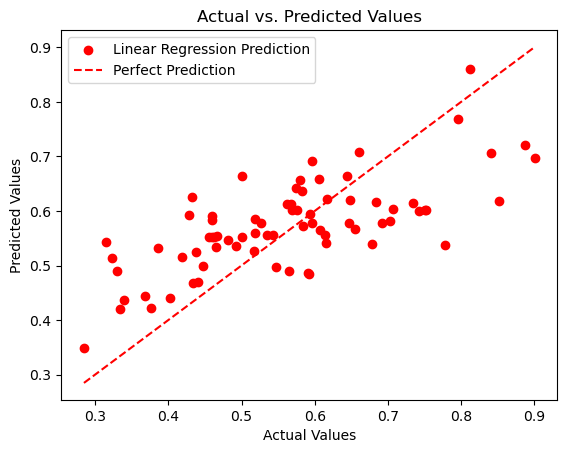

In [932]:
y_pred_lasso_cv = lasso_cv.predict(X_test)

plt.scatter(y_test, y_pred_lasso_cv, color='red', label='Linear Regression Prediction')

# Add a diagonal line representing perfect predictions
min_value = min(min(y_test), min(y_pred_lasso_cv))
max_value = max(max(y_test), max(y_pred_lasso_cv))
plt.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='red', label='Perfect Prediction')

# Customize the plot with labels, a title, and a legend
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()

# Show the plot or save it to a file
plt.show()

In [933]:
RMSEs = [np.sqrt(mse_linear),np.sqrt(mse_RF),np.sqrt(mse_lasso),np.sqrt(mse_xgb)]
model_names = ['Linear','Random Forest','Lasso Regression','XGBoost']

model_evaluation = pd.DataFrame({"RMSE":RMSEs, "Model":model_names})
model_evaluation

,RMSE,Model
0,0.101884,Linear
1,0.113719,Random Forest
2,0.099682,Lasso Regression
3,0.101135,XGBoost


# 5. Evaluation and Analysis

### Since the best model chosen was the linear model using Lasso Regularization, lets take a deeper look at the model and its coefficients

In [875]:
import statsmodels.api as sm

# Add a constant term (intercept) to the model
X_final = sm.add_constant(X[selected_features_lasso])

# Fit a linear model
model = sm.OLS(y, X_final).fit()

# Create a summary of the linear model
summary = model.summary()

# Print the summary
print(summary)

                            OLS Regression Results                            
Dep. Variable:     second_half_slgcon   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     27.58
Date:                Tue, 14 Nov 2023   Prob (F-statistic):           2.56e-36
Time:                        16:44:18   Log-Likelihood:                 343.00
No. Observations:                 374   AIC:                            -666.0
Df Residuals:                     364   BIC:                            -626.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.8978    

### In the above summary, In the summary shown in the code, we see that exit speed, hit distance, and hit_vert_exit_angle are the only predictors that are significant at a 0.05 alpha threshold. This means that essentially most of the variance in second half slugging can be explained by just these 3 variables. This makes sense because high slugging percentage is attributed to being able to hit the ball for extra bases and the features that most influence this are how hard and how far you hit the ball. Additionally, a high launch angle means you hit the ball in the air more and have a better chance of hitting the ball out of the park. 

### Looking at the coefficients, we can see that increasing your 90th percentile exit velocity by one mph can increase your slugging percentage by .011. Barrel is a feature engineered variable included in this model that is not significant with a p-value of 0.3, but it reinforces the idea that hitting the ball at high speeds at the right angle will lead to higher slugging percentage. 

### First half slugging makes sense as it sets a precedent for what a player will do in the second half. Most times, a player with a lower slugging percentage in the first half wont have a high slugging percentage in the second half and vice versa.

### The interaction terms included are interesting. Most of them have very high p-values and likely do not have a lot of predictive power, but one to look at is SameHand_BB_slg which has a p-value of 0.193. The positive coefficient for this interaction term indicates that the effect of one predictor on the response variable increases as the other predictor increases. If I would have to guess, this would be because hitters often perform worse against same handed pitchers. To add to this, sliders and curveballs coming from the same side are usually the hardest pitches to hit. If a player is able to slug well on both, they are likely very good hitters and will have a high slugging percentage in the second half. 

# 6. Make predictions

In [751]:
get_missing_val_columns(test_FHBB)

pitch_type                   1359
pitch_release_speed           268
pitch_spin_rate              1990
pitch_spin_axis               571
pitch_tilt                    577
pitch_release_height          268
pitch_release_side            268
pitch_extension               416
pitch_vert_break              307
pitch_induced_vert_break      307
pitch_horz_break              307
pitch_plate_height            264
pitch_plate_side              264
hit_exit_speed               6404
hit_vert_exit_angle          6392
hit_horz_exit_angle          6392
hit_spin_rate               18411
hit_distance                 7116
dtype: int64

In [752]:
test_FHBB[(test_FHBB.hit_exit_speed.isna()) & (test_FHBB.slg>1)]

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_tilt,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,event_type,slg
261,4,2019,x8bdc4302,4,1,5,x8736737a,R,x35b93f01,R,0,1,1,ChangeUp,81.338980,2057.413260,222.584316,01:30:00,6.084260,1.330157,6.282436,-28.429867,12.695241,11.702997,2.363485,0.541941,NaN,NaN,NaN,NaN,NaN,home_run,4
779,6,2021,x925d3460,1,0,5,x5ba330b4,R,x6a5b5e51,R,1,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,double,2
863,5,2017,xa55b2816,6,1,2,xbbf92f58,R,x797c41e0,R,2,0,1,Fastball,90.464495,2314.782252,203.151867,12:45:00,6.036789,0.852572,6.121026,-17.183373,16.691863,6.516406,2.083002,-0.197614,NaN,NaN,NaN,NaN,NaN,double,2
1176,6,2021,x0c39a1c3,3,0,6,x7d0c379b,R,xd55aca85,L,3,2,1,NaN,81.050962,1526.364550,104.087615,09:30:00,5.759030,-2.163165,6.974846,-31.028712,9.797517,-8.920480,2.561616,-1.030917,NaN,NaN,NaN,2181.355749,NaN,home_run,4
1210,5,2021,xd798f7f0,1,0,3,x79da10be,L,xa16f9b83,R,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,triple,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60757,5,2022,x62bd9fbe,9,0,1,x64cde92b,R,x95354bfe,L,1,2,0,Curveball,76.382880,1927.830348,311.131066,04:15:00,5.532220,-3.741010,6.388720,-59.610190,-11.889340,15.492170,1.238110,-0.502800,NaN,NaN,NaN,NaN,NaN,home_run,4
61124,4,2019,x1be6a386,7,1,1,x662d3a64,R,x329a37c1,R,0,0,0,Undefined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,home_run,4
61538,4,2022,x41485f2e,2,1,1,xa449e043,L,xa4d4e8a3,R,2,0,0,Four-Seam,91.187440,2064.863714,206.061937,12:45:00,7.092350,1.008860,5.623760,-15.556110,18.696700,8.569140,2.619840,-0.257290,NaN,NaN,NaN,NaN,NaN,home_run,4
61592,5,2018,x4e52db70,3,1,2,x70b26d0d,R,xd2379b56,L,0,1,0,Fastball,90.830469,2285.325892,162.072558,11:30:00,6.312749,-1.148552,6.432603,-17.560737,15.162442,-4.507761,2.338237,0.769698,NaN,NaN,NaN,NaN,NaN,double,2


### This data has many missing values in the columns that are important for modeling. For these missing values, we will replace them with the average based on player and slg. If that player has not had that type of hit before, fill na values with their average

In [786]:
test_FHBB = test_FHBB_original.copy()

In [787]:
test_FHBB['hit_distance'] = test_FHBB.groupby(['batter_id','season', 'slg'])['hit_distance'].transform(lambda x: x.fillna(x.mean()))
test_FHBB['hit_exit_speed'] = test_FHBB.groupby(['batter_id', 'season','slg'])['hit_exit_speed'].transform(lambda x: x.fillna(x.mean()))
test_FHBB['hit_vert_exit_angle'] = test_FHBB.groupby(['batter_id', 'season','slg'])['hit_vert_exit_angle'].transform(lambda x: x.fillna(x.mean()))

In [788]:
test_FHBB['hit_distance'] = test_FHBB.groupby(['batter_id'])['hit_distance'].transform(lambda x: x.fillna(x.mean()))
test_FHBB['hit_exit_speed'] = test_FHBB.groupby(['batter_id'])['hit_exit_speed'].transform(lambda x: x.fillna(x.mean()))
test_FHBB['hit_vert_exit_angle'] = test_FHBB.groupby(['batter_id'])['hit_vert_exit_angle'].transform(lambda x: x.fillna(x.mean()))

In [832]:
len(test_FHBB)

62247

### Create feature engineered variables we need for the new predictions. This is just everything we previously did with the initial training dataset

In [789]:
test_FHBB['barrel'] = test_FHBB.apply(barrel,axis=1)
test_FHBB['same_hand'] = test_FHBB.apply(same_hand,axis=1)f
test_FHBB['ground_ball'] = test_FHBB['hit_vert_exit_angle'].apply(lambda x: ground_ball(x))
test_FHBB['pitch_type'] = test_FHBB['pitch_type'].apply(lambda x: pitch_categorization(x))

In [829]:
test_FHBB_final = get_slg_by_groups(test_FHBB,'pitch_type')

In [830]:
test_FHBB_final = get_slg_by_groups(test_FHBB_final,'same_hand')

In [831]:
get_missing_val_columns(test_FHBB_final)

pitch_release_speed           268
pitch_spin_rate              1990
pitch_spin_axis               571
pitch_tilt                    577
pitch_release_height          268
pitch_release_side            268
pitch_extension               416
pitch_vert_break              307
pitch_induced_vert_break      307
pitch_horz_break              307
pitch_plate_height            264
pitch_plate_side              264
hit_horz_exit_angle          6392
hit_spin_rate               18411
Changeup_avg_slg              221
Other_avg_slg                6177
Same_Hand_avg_slg            4785
dtype: int64

### Some important values are still missing so we impute them with the average slg based on batter and season

In [868]:
test_FHBB_final['Changeup_avg_slg'] = test_FHBB_final.groupby(['batter_id','season'])['slg'].transform(lambda x: x.fillna(x.mean()))
test_FHBB_final['Same_Hand_avg_slg'] = test_FHBB_final.groupby(['batter_id','season'])['slg'].transform(lambda x: x.fillna(x.mean()))

get_missing_val_columns(test_FHBB_final)

pitch_release_speed           268
pitch_spin_rate              1990
pitch_spin_axis               571
pitch_tilt                    577
pitch_release_height          268
pitch_release_side            268
pitch_extension               416
pitch_vert_break              307
pitch_induced_vert_break      307
pitch_horz_break              307
pitch_plate_height            264
pitch_plate_side              264
hit_horz_exit_angle          6392
hit_spin_rate               18411
Other_avg_slg                6177
dtype: int64

### Again group the data based on batter and season

In [987]:
percentile_cols_final = ['hit_exit_speed','hit_distance']
mean_cols_final = ['hit_horz_exit_angle','hit_vert_exit_angle','BreakingBall_avg_slg','Changeup_avg_slg', 'Fastball_avg_slg','Opposite_Hand_avg_slg', 'Same_Hand_avg_slg','slg','barrel','ground_ball']

aggregations_final = ({col: lambda x: np.percentile(x, 90) for col in percentile_cols_final})
aggregations_final.update({col: 'mean' for col in mean_cols_final})

final_x = test_FHBB_final.groupby(['batter_id','season']).agg(aggregations_final)

In [870]:
get_missing_val_columns(final_x)

Series([], dtype: int64)

### Create only the interaction terms we need for the model

In [871]:
final_x['FB_CH_slg'] = final_x['Fastball_avg_slg'] * final_x['Changeup_avg_slg']

final_x['SameHand_BB_slg'] = final_x['Same_Hand_avg_slg'] * final_x['BreakingBall_avg_slg']

final_x['OppHand_FB_slg'] = final_x['Opposite_Hand_avg_slg'] * final_x['Fastball_avg_slg']

final_x['OppHand_CH_slg'] = final_x['Opposite_Hand_avg_slg'] * final_x['Changeup_avg_slg']

### Make Predictions

In [880]:
predicted_y = model.predict(sm.add_constant(final_x[selected_features_lasso]))

In [895]:
predicted_df = pd.DataFrame(predicted_y)
predicted_df.reset_index(inplace=True)
predicted_df.rename(columns = {0:'second_half_slgcon'},inplace=True)
predicted_df

,batter_id,season,second_half_slgcon
0,x0096d996,2023,0.652196
1,x00c9f5ea,2017,0.760215
2,x01c777c8,2017,0.415114
3,x02b7e19c,2017,0.471923
4,x02b7e19c,2018,0.385423
...,...,...,...
370,xfb154453,2018,0.567373
371,xfb3cc6b0,2023,0.581325
372,xfbe84e9a,2023,0.520653
373,xfc405059,2022,0.602226


### Write prediction dataframe to a csv

In [1023]:
test_submission_df_final = test_submission_df.merge(predicted_df,on=['season','batter_id'],how='left')
test_submission_df_final.to_csv('predicted_slg_submission.csv')

# Question 2:

### Create new features that indicate if a batted ball resulted in a hit, xbh, or home run.
### Also create a feature that indicates if 2 out contact was made, 2 out hit occured, or late inning hit

In [1009]:
test_FHBB_final['count'] = 1
test_FHBB_final['hit'] = test_FHBB_final.slg.apply(lambda x: 1 if x>0 else 0)
test_FHBB_final['home_run'] = test_FHBB_final.slg.apply(lambda x: 1 if x==4 else 0)
test_FHBB_final['xbh'] = test_FHBB_final.slg.apply(lambda x: 1 if x>1 else 0)
test_FHBB_final['2_out_contact'] = test_FHBB_final.pre_outs.apply(lambda x: 1 if x==2 else 0)



def two_out_hit(row):
    if((row['slg']>0) & (row['pre_outs']==2)):
        return 1
    else: 
        return 0
    
    
def late_inning_hit(row):
    if((row['slg']>0) & (row['inning']>=7)):
        return 1
    else: 
        return 0


test_FHBB_final['2_out_hit'] = test_FHBB_final.apply(two_out_hit,axis=1)
test_FHBB_final['late_inning_hit'] = test_FHBB_final.apply(late_inning_hit,axis=1)




p_xe5 = test_FHBB_final[test_FHBB_original.batter_id == "xe54ef656"]
p_x08 = test_FHBB_final[test_FHBB_original.batter_id == "x084802d3"]

,month,season,game_id,inning,top,pa_of_inning,batter_id,bat_side,pitcher_id,pitch_side,pre_balls,pre_strikes,pre_outs,pitch_type,pitch_release_speed,pitch_spin_rate,pitch_spin_axis,pitch_tilt,pitch_release_height,pitch_release_side,pitch_extension,pitch_vert_break,pitch_induced_vert_break,pitch_horz_break,pitch_plate_height,pitch_plate_side,hit_exit_speed,hit_vert_exit_angle,hit_horz_exit_angle,hit_spin_rate,hit_distance,event_type,slg,barrel,same_hand,ground_ball,BreakingBall_avg_slg,Changeup_avg_slg,Fastball_avg_slg,Other_avg_slg,Opposite_Hand_avg_slg,Same_Hand_avg_slg,count,hit,home_run,xbh,2_out_hit,2_out_contact,late_inning_hit
1140,5,2023,xfade5d04,7,0,2,xe54ef656,L,xc4083a81,R,0,0,1,Fastball,95.744308,2066.596263,237.006200,02:00:00,5.432272,1.358601,6.558762,-28.112454,1.807355,16.259622,2.431479,0.058538,111.897951,17.803088,15.979186,1896.320324,313.3520,field_out,0,1,Opposite_Hand,0,0.411765,0,0.794118,0.0,0.638298,0,1,0,0,0,0,0,0
1415,5,2023,x9ad85c9f,6,1,2,xe54ef656,L,xb780a6ae,R,2,0,0,Fastball,88.975590,1971.729502,192.862656,12:30:00,5.501341,2.188652,6.546174,-25.990432,8.352125,-2.481609,2.041716,-0.255821,106.324290,46.017348,25.266290,4538.488793,337.4240,field_out,0,0,Opposite_Hand,0,0.411765,0,0.794118,0.0,0.638298,0,1,0,0,0,0,0,0
3589,5,2023,x73bbf9aa,8,1,2,xe54ef656,L,xa6aabaa1,R,3,1,1,Fastball,96.882953,2164.782438,224.003885,01:30:00,6.258553,2.218824,6.142937,-13.810383,15.426702,9.155237,3.193308,0.835123,98.837447,53.661457,-20.304226,5278.117313,258.2670,field_out,0,0,Opposite_Hand,0,0.411765,0,0.794118,0.0,0.638298,0,1,0,0,0,0,0,0
4021,6,2019,x29cf5f7d,8,0,1,xe54ef656,L,x0f1e2ff1,R,1,0,0,Changeup,90.416564,1831.088571,217.124687,01:15:00,6.730850,2.329022,5.565166,-19.981109,14.097307,10.695516,2.373020,-0.024792,98.647289,26.132596,30.575633,3318.670783,372.8670,home_run,4,1,Opposite_Hand,0,0.631579,4,0.787879,0.5,0.657534,4,1,1,1,1,0,0,1
4428,5,2023,xd148bab9,3,0,5,xe54ef656,L,x0c6d825d,R,3,1,2,Fastball,93.684466,2184.646247,209.630198,01:00:00,6.365628,1.504924,6.621564,-11.075285,19.923041,11.914008,4.140559,0.570593,91.614722,23.486054,-2.948184,1687.871988,319.8670,field_out,0,0,Opposite_Hand,0,0.411765,0,0.794118,0.0,0.638298,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60943,6,2019,xb0c60ec7,1,0,5,xe54ef656,L,x6bd3ec6f,L,0,0,1,Fastball,90.217481,2304.081527,152.886191,11:00:00,5.832261,-3.584083,6.369024,-19.511430,13.552602,-6.955257,1.824890,-0.124737,104.397280,28.954828,0.283083,3311.038887,463.0160,home_run,4,1,Same_Hand,0,0.631579,4,0.787879,0.5,0.657534,4,1,1,1,1,0,0,0
61311,4,2023,x4fcb9737,5,0,1,xe54ef656,L,x68f63e9b,R,0,2,0,Fastball,92.052063,NaN,NaN,NaN,6.454712,1.133082,6.466273,-24.690500,7.370713,16.319471,2.537369,-0.212943,102.112533,-3.066069,21.727507,2325.543559,32.6137,field_out,0,0,Opposite_Hand,1,0.411765,0,0.794118,0.0,0.638298,0,1,0,0,0,0,0,0
61810,4,2019,xf8ea5c19,8,0,5,xe54ef656,L,xb9782985,R,0,0,1,BreakingBall,83.714687,2501.094291,87.367799,09:00:00,6.082570,2.311303,5.374805,-40.712333,-0.322331,-6.185282,2.711239,0.061609,83.844918,15.709271,30.919345,2705.949674,198.9300,single,1,0,Opposite_Hand,0,0.631579,1,0.787879,0.5,0.657534,1,1,1,0,0,0,0,1
61843,5,2019,x8136e4bd,1,0,4,xe54ef656,L,xc92dea58,R,2,1,2,Changeup,82.873034,1435.030501,209.661014,01:00:00,6.296247,1.992701,5.860086,-27.199449,13.175857,7.525118,1.588920,0.034068,100.528597,28.811022,33.431510,2923.242247,386.8480,home_run,4,1,Opposite_Hand,0,0.631579,4,0.787879,0.5,0.657534,4,1,1,1,1,1,1,0


In [1013]:
aggregations_final['count'] = 'sum'
aggregations_final['hit'] = 'sum'
aggregations_final['home_run'] = 'sum'
aggregations_final['xbh'] = 'sum'
aggregations_final['2_out_hit'] = 'sum'
aggregations_final['late_inning_hit'] = 'sum'
aggregations_final['2_out_contact'] = 'sum'
aggregations_final['hit_exit_speed'] = 'mean'

### Player x084802d3 statistics 

In [1014]:
p_x08_agg = p_x08.groupby(['batter_id','season']).agg(aggregations_final)
p_x08_agg

,,hit_exit_speed,hit_distance,hit_horz_exit_angle,hit_vert_exit_angle,BreakingBall_avg_slg,Changeup_avg_slg,Fastball_avg_slg,Opposite_Hand_avg_slg,Same_Hand_avg_slg,slg,barrel,ground_ball,count,hit,home_run,xbh,2_out_hit,late_inning_hit,2_out_contact
batter_id,season,,,,,,,,,,,,,,,,,,,
x084802d3,2023,84.890595,293.3955,0.969824,-3.240501,0.69697,0.493671,0.5,0.504132,0.493671,0.493671,0.012658,0.677215,158,60,2,12,21,13,43


### Player xe54ef656 statistics

In [1015]:
p_xe5_agg = p_xe5.groupby(['batter_id','season']).agg(aggregations_final)
p_xe5_agg

hit_exit_speed  hit_distance  hit_horz_exit_angle  \
batter_id season                                                      
xe54ef656 2019         86.241692      391.6465             8.212926   
          2023         89.273133      375.3079             9.994830   

                  hit_vert_exit_angle  BreakingBall_avg_slg  Changeup_avg_slg  \
batter_id season                                                                
xe54ef656 2019              17.626913              0.631579          0.740741   
          2023              11.600735              0.411765          0.620968   

                  Fastball_avg_slg  Opposite_Hand_avg_slg  Same_Hand_avg_slg  \
batter_id season                                                               
xe54ef656 2019            0.787879               0.657534           0.740741   
          2023            0.794118               0.638298           0.620968   

                       slg    barrel  ground_ball  count  hit  home_run  xbh  \
batter_id season                                                               
xe54ef656 2019    0.740741  0.064815     0.259259    108   41         9   21   
          2023    0.620968  0.104839     0.491935    124   35        11   20   

                  2_out_hit  late_inning_hit  2_out_contact  
batter_id season                                             
xe54ef656 2019           12               18             35  
          2023           10               15             39